In [1]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import h5py
from tqdm.notebook import tqdm
import torchcde
from scipy.signal import find_peaks

In [34]:
with h5py.File('/work/hmzhao/irregular-lc/KMT-test.h5', mode='r') as dataset_file:
    Y = torch.tensor(dataset_file['Y'][...])
    X = torch.tensor(dataset_file['X'][...])

# filter nan
nanind = torch.where(~torch.isnan(X[:, 0, 1]))[0]
Y = Y[nanind]
X = X[nanind]
nanind = torch.where(Y[:, 2]>0)[0]
Y = Y[nanind]
X = X[nanind]
nanind = torch.where(Y[:, 2]<1)[0]
Y = Y[nanind]
X = X[nanind]

Y[:, 3:6] = torch.log10(Y[:, 3:6])
Y[:, -1] = torch.log10(Y[:, -1])
Y[:, 6] = Y[:, 6] / 180
Y = Y[:, 2:]
print('Shape of Y: ', Y.shape)

X[:, :, 1] = (X[:, :, 1] - 14.5 - 2.5 * Y[:, [-1]]) / 0.2
print(f'normalized X mean: {torch.mean(X[:, :, 1])}\nX std: {torch.mean(torch.std(X[:, :, 1], axis=0))}')

X = X[:, :, :2]
    
# CDE interpolation with log_sig
depth = 3; window_length = 5
logsig = torchcde.logsig_windows(X, depth, window_length=window_length)
coeffs = torchcde.hermite_cubic_coefficients_with_backward_differences(logsig)

Shape of Y:  torch.Size([99677, 6])
normalized X mean: -1.1799484138211669
X std: 1.0505892613255765


In [3]:
from model.cde_mdn import CDE_MDN

device = torch.device("cuda:7" if torch.cuda.is_available() else "cpu")

checkpt = torch.load('/work/hmzhao/experiments/cde_mdn/experiment_2.ckpt', map_location='cpu')
ckpt_args = checkpt['args']
state_dict = checkpt['state_dict']

output_dim = Y.shape[-1]
input_dim = logsig.shape[-1]
latent_dim = ckpt_args.latents

model = CDE_MDN(input_dim, latent_dim, output_dim).to(device)
model_dict = model.state_dict()

# 1. filter out unnecessary keys
state_dict = {k: v for k, v in state_dict.items() if k in model_dict}
# 2. overwrite entries in the existing state dict
model_dict.update(state_dict) 
# 3. load the new state dict
model.load_state_dict(state_dict)
model.to(device)

CDE_MDN(
  (cde_func): CDEFunc(
    (linear1): Linear(in_features=32, out_features=1024, bias=True)
    (relu1): PReLU(num_parameters=1)
    (resblocks): Sequential(
      (0): ResBlock(
        (linear1): Linear(in_features=1024, out_features=1024, bias=True)
        (nonlinear1): PReLU(num_parameters=1)
        (linear2): Linear(in_features=1024, out_features=1024, bias=True)
      )
      (1): ResBlock(
        (linear1): Linear(in_features=1024, out_features=1024, bias=True)
        (nonlinear1): PReLU(num_parameters=1)
        (linear2): Linear(in_features=1024, out_features=1024, bias=True)
      )
      (2): ResBlock(
        (linear1): Linear(in_features=1024, out_features=1024, bias=True)
        (nonlinear1): PReLU(num_parameters=1)
        (linear2): Linear(in_features=1024, out_features=1024, bias=True)
      )
    )
    (relu2): PReLU(num_parameters=1)
    (linear2): Linear(in_features=1024, out_features=160, bias=True)
    (tanh): Tanh()
    (linear3): Linear(in_features=

In [15]:
num = 4096 * 4
batchsize = 4096 * 4
n_gaussian = model.n_gaussian
pis = torch.zeros((num, n_gaussian))
locs = torch.zeros((num, n_gaussian, output_dim))
scales = torch.zeros((num, n_gaussian, output_dim))
model.eval()
with torch.no_grad():
    for i in tqdm(range(int(np.ceil(num / batchsize)))):
        batch = coeffs[i*batchsize:min(i*batchsize+batchsize, num)].float().to(device)
        pi, normal = model(batch)
        pis[i*batchsize:min(i*batchsize+batchsize, num)] = pi.probs.detach().cpu()
        locs[i*batchsize:min(i*batchsize+batchsize, num)] = normal.loc.detach().cpu()
        scales[i*batchsize:min(i*batchsize+batchsize, num)] = normal.scale.detach().cpu()

  0%|          | 0/1 [00:00<?, ?it/s]

In [16]:
def get_loglik(pi, loc, scale, x, margin_dim, exp=False):
    shape = x.shape
    loc = loc[..., margin_dim]
    scale = scale[..., margin_dim]
    normal = torch.distributions.Normal(loc, scale)
    x = x.reshape(-1, loc.shape[0], 1).tile(1, loc.shape[-1])
    loglik = normal.log_prob(x).reshape(*shape[:-1], -1)
    loglik = torch.logsumexp(torch.log(pi) + loglik, dim=-1)
    if exp:
        return torch.exp(loglik)
    return loglik

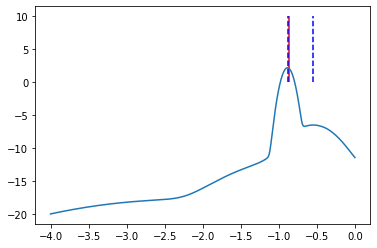

In [17]:
i = 0
qgrid = torch.linspace(-4, 0, 1000)
qlist = qgrid.reshape(-1, 1, 1).tile(1, num, 1)
plt.plot(np.linspace(-4, 0, 1000), get_loglik(pis, locs, scales, qlist, margin_dim=2, exp=False)[:, i])
peaks = find_peaks(get_loglik(pis, locs, scales, qlist, margin_dim=2, exp=False).transpose(1, 0)[i])[0]
plt.vlines(Y[i, 2], 0, 10, color='red')
plt.vlines(np.linspace(-4, 0, 1000)[peaks], 0, 10, color='blue', linestyles='dashed')

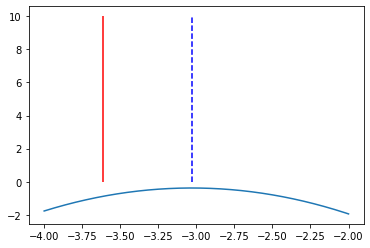

In [18]:
i = 4
qgrid = torch.linspace(-4, -2, 1000)
qlist = qgrid.reshape(-1, 1, 1).tile(1, num, 1)
plt.plot(qgrid, get_loglik(pis, locs, scales, qlist, margin_dim=1, exp=False)[:, i])
peaks = find_peaks(get_loglik(pis, locs, scales, qlist, margin_dim=1, exp=False).transpose(1, 0)[i])[0]
plt.vlines(Y[i, 1], 0, 10, color='red')
plt.vlines(qgrid[peaks], 0, 10, color='blue', linestyles='dashed')

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

no peak found, use maximum instead
tensor(0.9318, dtype=torch.float64)


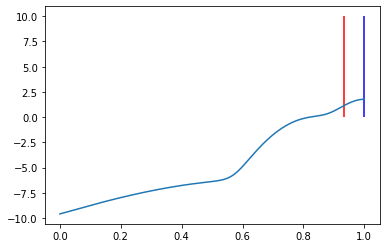

no peak found, use maximum instead
tensor(0.9011, dtype=torch.float64)


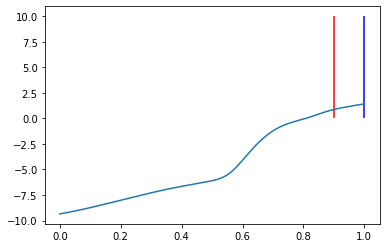

no peak found, use maximum instead
tensor(0.0123, dtype=torch.float64)


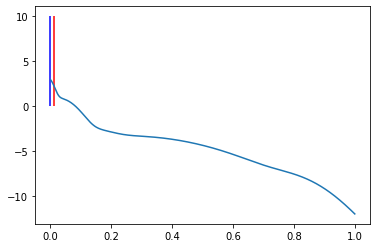

no peak found, use maximum instead
tensor(0.8740, dtype=torch.float64)


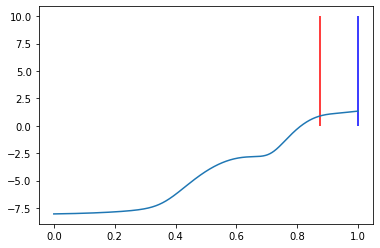

no peak found, use maximum instead
tensor(0.9557, dtype=torch.float64)


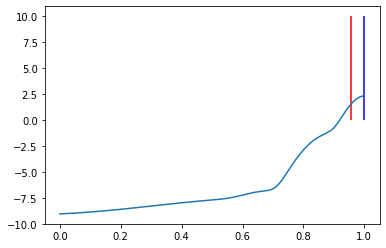

no peak found, use maximum instead
tensor(0.9772, dtype=torch.float64)


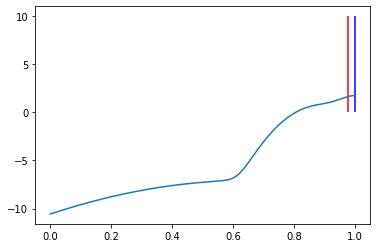

no peak found, use maximum instead
tensor(0.9710, dtype=torch.float64)


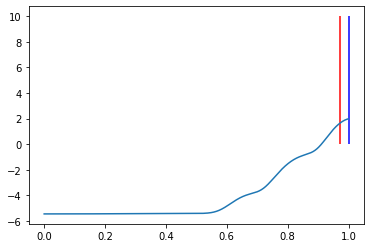

no peak found, use maximum instead
tensor(0.9282, dtype=torch.float64)


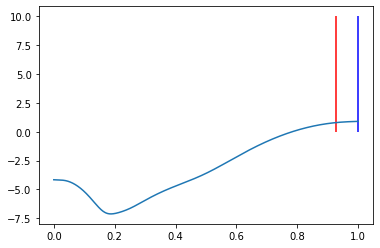

no peak found, use maximum instead
tensor(0.0028, dtype=torch.float64)


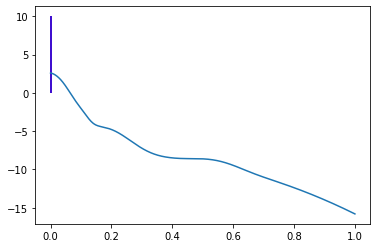

no peak found, use maximum instead
tensor(0.9531, dtype=torch.float64)


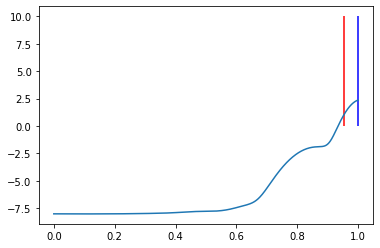

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

no peak found, use maximum instead
tensor(-0.0631, dtype=torch.float64)


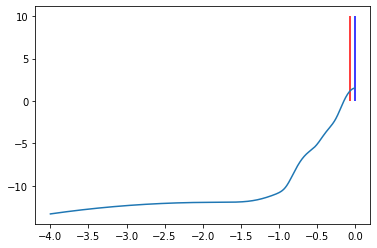

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

no peak found, use maximum instead
tensor(-0.9341, dtype=torch.float64)


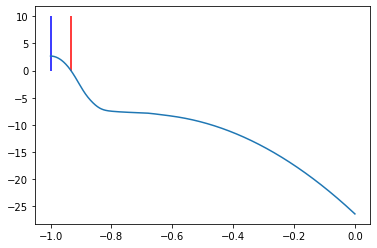

no peak found, use maximum instead
tensor(-0.9471, dtype=torch.float64)


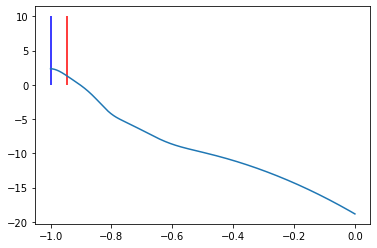

no peak found, use maximum instead
tensor(-0.9861, dtype=torch.float64)


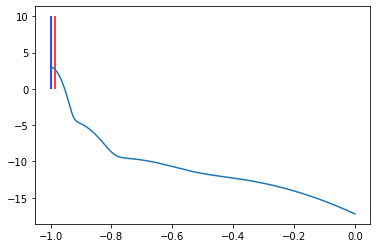

no peak found, use maximum instead
tensor(-0.9632, dtype=torch.float64)


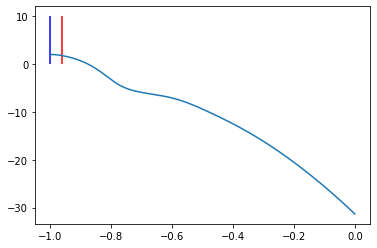

no peak found, use maximum instead
tensor(-0.9742, dtype=torch.float64)


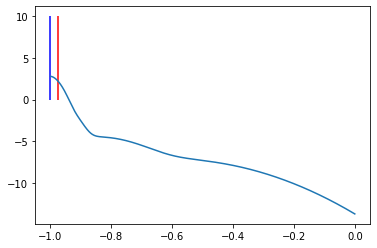

no peak found, use maximum instead
tensor(-0.0318, dtype=torch.float64)


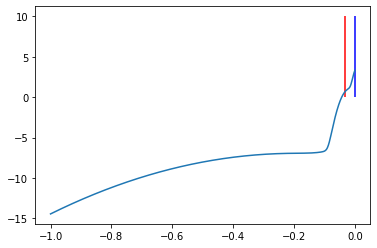

no peak found, use maximum instead
tensor(-0.9747, dtype=torch.float64)


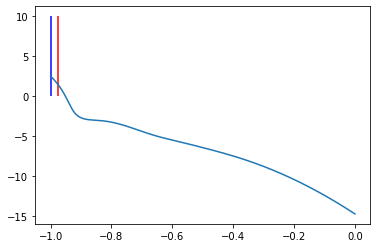

no peak found, use maximum instead
tensor(-0.9892, dtype=torch.float64)


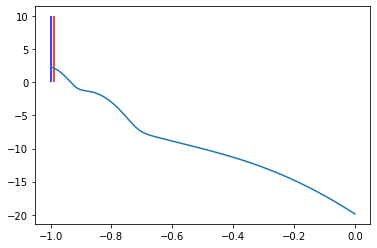

no peak found, use maximum instead
tensor(-0.7671, dtype=torch.float64)


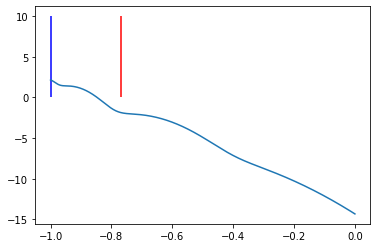

no peak found, use maximum instead
tensor(-0.0392, dtype=torch.float64)


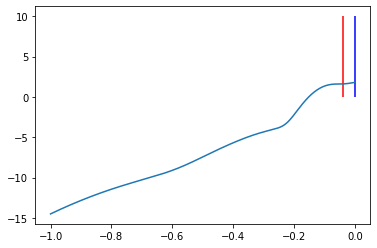

no peak found, use maximum instead
tensor(-0.0040, dtype=torch.float64)


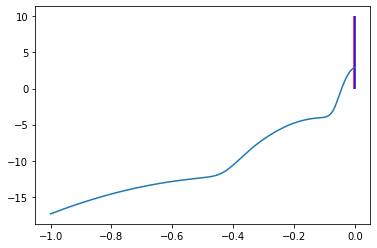

no peak found, use maximum instead
tensor(-0.9780, dtype=torch.float64)


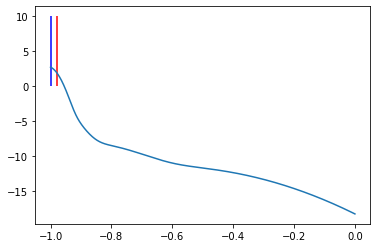

no peak found, use maximum instead
tensor(-0.9280, dtype=torch.float64)


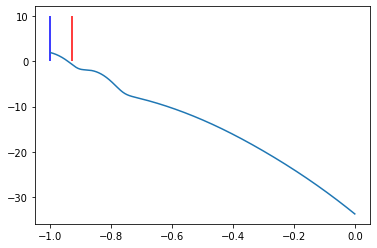

no peak found, use maximum instead
tensor(-0.9854, dtype=torch.float64)


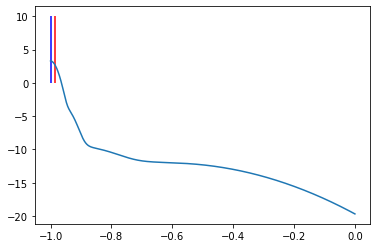

no peak found, use maximum instead
tensor(-0.9882, dtype=torch.float64)


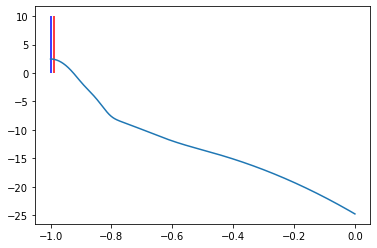

no peak found, use maximum instead
tensor(-0.9877, dtype=torch.float64)


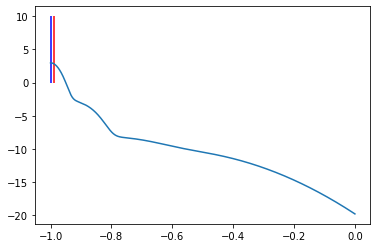

no peak found, use maximum instead
tensor(-0.9811, dtype=torch.float64)


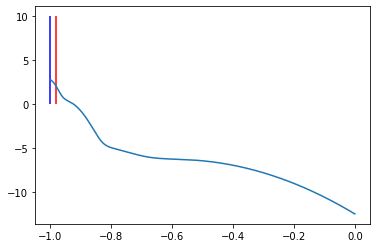

no peak found, use maximum instead
tensor(-0.9749, dtype=torch.float64)


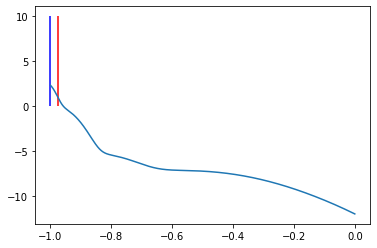

no peak found, use maximum instead
tensor(-0.9413, dtype=torch.float64)


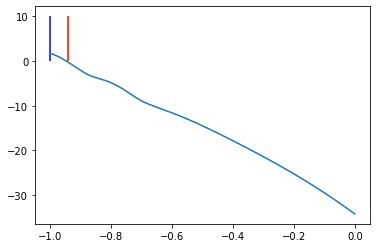

no peak found, use maximum instead
tensor(-0.0169, dtype=torch.float64)


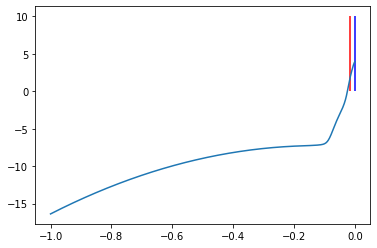

no peak found, use maximum instead
tensor(-0.9852, dtype=torch.float64)


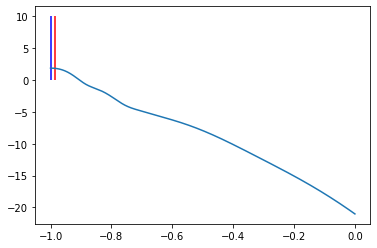

no peak found, use maximum instead
tensor(-0.9936, dtype=torch.float64)


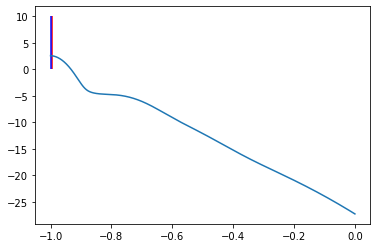

no peak found, use maximum instead
tensor(-0.9938, dtype=torch.float64)


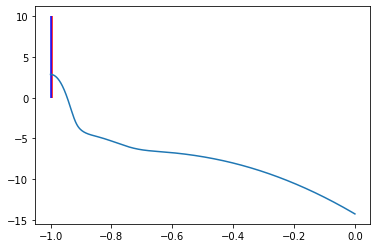

no peak found, use maximum instead
tensor(-0.9851, dtype=torch.float64)


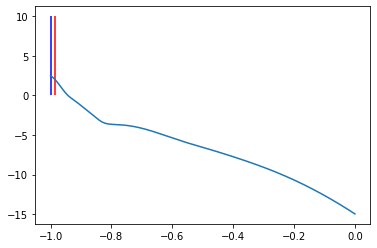

no peak found, use maximum instead
tensor(-0.9922, dtype=torch.float64)


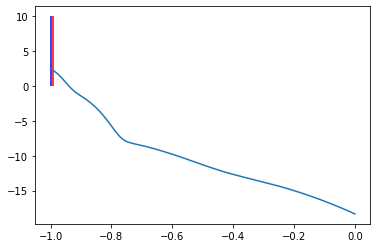

no peak found, use maximum instead
tensor(-0.0077, dtype=torch.float64)


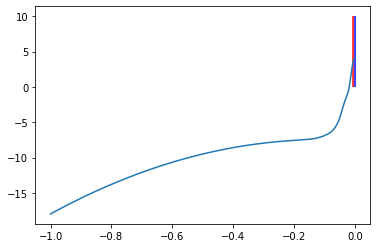

no peak found, use maximum instead
tensor(-0.0099, dtype=torch.float64)


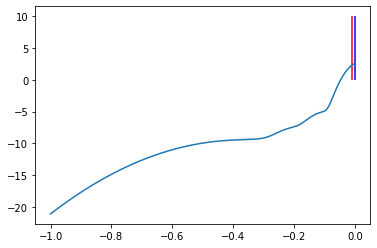

no peak found, use maximum instead
tensor(-0.0022, dtype=torch.float64)


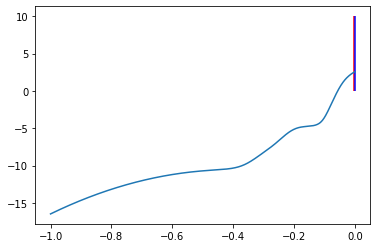

no peak found, use maximum instead
tensor(-0.9813, dtype=torch.float64)


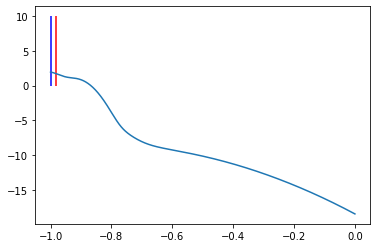

no peak found, use maximum instead
tensor(-0.9775, dtype=torch.float64)


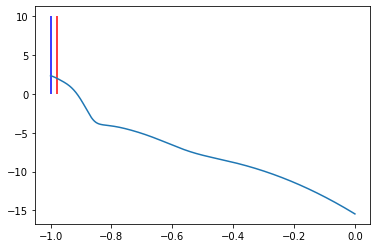

no peak found, use maximum instead
tensor(-0.9688, dtype=torch.float64)


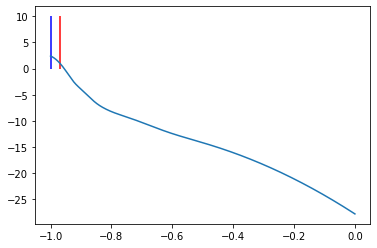

no peak found, use maximum instead
tensor(-0.9971, dtype=torch.float64)


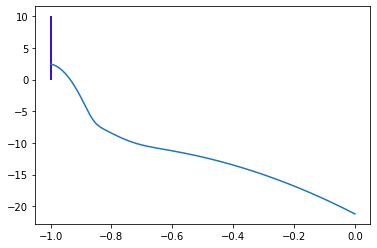

no peak found, use maximum instead
tensor(-0.9612, dtype=torch.float64)


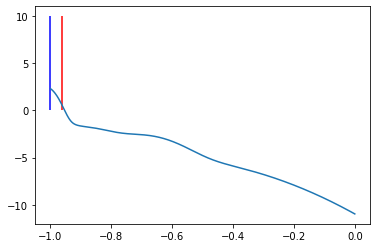

In [19]:
pred_global = torch.zeros((num, output_dim))
pred_global_loglik = torch.zeros((num, output_dim))
pred_close = torch.zeros((num, output_dim))
pred_close_loglik = torch.zeros((num, output_dim))
n_step = 1000
grid = [torch.linspace(0, 1, n_step),
        torch.linspace(-4, -2, n_step),
        torch.linspace(-4, 0, n_step),
        torch.linspace(-0.6, 0.6, n_step),
        torch.linspace(0, 2, n_step),
        torch.linspace(-1, 0, n_step)]
for dim in tqdm(range(output_dim)):
    param_list = grid[dim].reshape(-1, 1, 1).tile(1, num, 1) 
    loglik = get_loglik(pis, locs, scales, param_list, margin_dim=dim, exp=False).transpose(1, 0)
    for i in tqdm(range(num)):
        peaks = find_peaks(loglik[i])[0]
        if len(peaks) == 0:
            print('no peak found, use maximum instead')
            pred_global[i, dim] = grid[dim][torch.argmax(loglik[i])]
            pred_close[i, dim] = grid[dim][torch.argmax(loglik[i])]
            pred_global_loglik[i, dim] = torch.max(loglik[i])
            pred_close_loglik[i, dim] = torch.max(loglik[i])
            plt.plot(grid[dim], loglik[i])
            plt.vlines(Y[i, dim], 0, 10, color='red')
            plt.vlines(grid[dim][torch.argmax(loglik[i])], 0, 10, color='blue')
            print(Y[i, dim])
            plt.show()
        else:
            order = torch.argsort(loglik[i, peaks], descending=True)
            global_peak = grid[dim][peaks[order[0]]]
            close_peak = grid[dim][peaks][torch.argmin((grid[dim][peaks] - Y[i, dim])**2)]
            pred_global[i, dim] = global_peak
            pred_close[i, dim] = close_peak
            pred_global_loglik[i, dim] = loglik[i][peaks[order[0]]]
            pred_close_loglik[i, dim] = loglik[i][peaks][torch.argmin((grid[dim][peaks] - Y[i, dim])**2)]

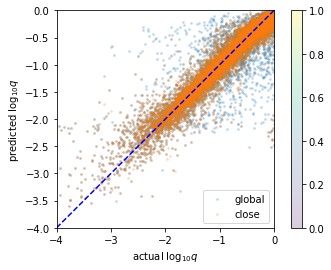

mse of log10q global:  0.058362302368573385
mse of log10q close:  0.03006466323327952
constraint 0.99847412109375
correct 0.9240173604743567


In [20]:
plt.axis('square')
plt.xlim(-4, 0)
plt.ylim(-4, 0)
plt.xlabel(r'actual $\log_{10}q$')
plt.ylabel(r'predicted $\log_{10}q$')
plt.scatter(Y[:num, 2], pred_global.numpy()[:num, 2], s=3, cmap='Blues', label='global', alpha=0.2)
plt.scatter(Y[:num, 2], pred_close.numpy()[:num, 2], s=3, cmap='Oranges', label='close', alpha=0.2)
plt.plot(np.linspace(-4, 0), np.linspace(-4, 0), color='b', linestyle='dashed')
plt.colorbar()
plt.legend()
plt.show()
print('mse of log10q global: ', torch.mean((Y[:num, 2] -  pred_global.numpy()[:num, 2])**2).detach().cpu().item())
print('mse of log10q close: ', torch.mean((Y[:num, 2] -  pred_close.numpy()[:num, 2])**2).detach().cpu().item())
constraint_ind = pred_global_loglik[:num, 2]>np.log(2*1/4)
print('constraint', torch.sum(constraint_ind).item()/num)
print('correct', torch.sum(pred_global[:num, 2][constraint_ind]==pred_close[:num, 2][constraint_ind]).item()/torch.sum(constraint_ind).item())

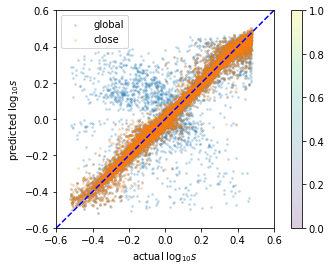

mse of log10s global:  0.010153515189013857
mse of log10s close:  0.0010986313658710796
constraint 0.99688720703125
correct 0.8945080511847181


In [21]:
plt.axis('square')
plt.xlim(-0.6, 0.6)
plt.ylim(-0.6, 0.6)
plt.xlabel(r'actual $\log_{10}s$')
plt.ylabel(r'predicted $\log_{10}s$')
plt.scatter(Y[:num, 3], pred_global.numpy()[:num, 3], s=3, cmap='Blues', label='global', alpha=0.2)
plt.scatter(Y[:num, 3], pred_close.numpy()[:num, 3], s=3, cmap='Oranges', label='close', alpha=0.2)
plt.plot(np.linspace(-0.6, 0.6), np.linspace(-0.6, 0.6), color='b', linestyle='dashed')
plt.colorbar()
plt.legend()
plt.show()
print('mse of log10s global: ', torch.mean((Y[:num, 3] -  pred_global.numpy()[:num, 3])**2).detach().cpu().item())
print('mse of log10s close: ', torch.mean((Y[:num, 3] -  pred_close.numpy()[:num, 3])**2).detach().cpu().item())
constraint_ind = pred_global_loglik[:num, 3]>np.log(2*1/1.2)
print('constraint', torch.sum(constraint_ind).item()/num)
print('correct', torch.sum(pred_global[:num, 3][constraint_ind]==pred_close[:num, 3][constraint_ind]).item()/torch.sum(constraint_ind).item())

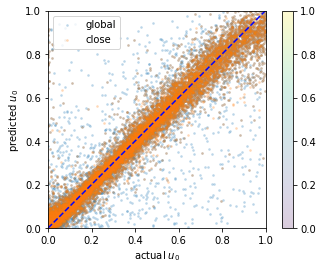

mse of u0:  0.008868554798017445
mse of u0:  0.003566486558472356
constraint 0.9898681640625
correct 0.9110864471574793


In [22]:
plt.axis('square')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel(r'actual $u_0$')
plt.ylabel(r'predicted $u_0$')
plt.scatter(Y[:num, 0], pred_global.numpy()[:num, 0], s=3, cmap='Blues', label='global', alpha=0.2)
plt.scatter(Y[:num, 0], pred_close.numpy()[:num, 0], s=3, cmap='Oranges', label='close', alpha=0.2)
plt.plot(np.linspace(0, 1), np.linspace(0, 1), color='b', linestyle='dashed')
plt.colorbar()
plt.legend()
plt.show()
print('mse of u0: ', torch.mean((Y[:num, 0] -  pred_global.numpy()[:num, 0])**2).detach().cpu().item())
print('mse of u0: ', torch.mean((Y[:num, 0] -  pred_close.numpy()[:num, 0])**2).detach().cpu().item())
constraint_ind = pred_global_loglik[:num, 0]>np.log(2*1/1)
print('constraint', torch.sum(constraint_ind).item()/num)
print('correct', torch.sum(pred_global[:num, 0][constraint_ind]==pred_close[:num, 0][constraint_ind]).item()/torch.sum(constraint_ind).item())

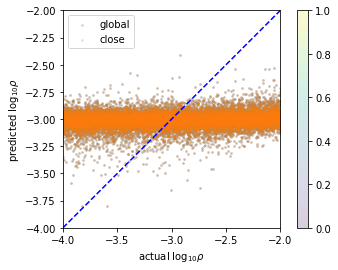

mse of log10rho global:  0.3255600616113431
mse of log10rho close:  0.3255600616113431
constraint 0.00018310546875
correct 1.0


In [23]:
plt.axis('square')
plt.xlim(-4, -2)
plt.ylim(-4, -2)
plt.xlabel(r'actual $\log_{10}\rho$')
plt.ylabel(r'predicted $\log_{10}\rho$')
plt.scatter(Y[:num, 1], pred_global.numpy()[:num, 1], s=3, cmap='Blues', label='global', alpha=0.2)
plt.scatter(Y[:num, 1], pred_close.numpy()[:num, 1], s=3, cmap='Oranges', label='close', alpha=0.2)
plt.plot(np.linspace(-4, -2), np.linspace(-4, -2), color='b', linestyle='dashed')
plt.colorbar()
plt.legend()
plt.show()
print('mse of log10rho global: ', torch.mean((Y[:num, 1] -  pred_global.numpy()[:num, 1])**2).detach().cpu().item())
print('mse of log10rho close: ', torch.mean((Y[:num, 1] -  pred_close.numpy()[:num, 1])**2).detach().cpu().item())
constraint_ind = pred_global_loglik[:num, 1]>np.log(2*1/2)
print('constraint', torch.sum(constraint_ind).item()/num)
print('correct', torch.sum(pred_global[:num, 1][constraint_ind]==pred_close[:num, 1][constraint_ind]).item()/torch.sum(constraint_ind).item())

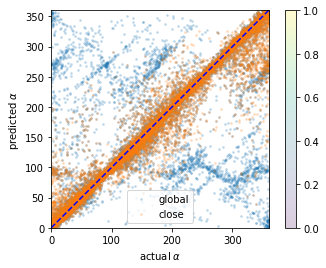

mse of alpha global:  5237.476277896838
mse of alpha close:  651.4295109187334
constraint 0.97674560546875
correct 0.830031869024558


In [24]:
plt.axis('square')
plt.xlim(0, 360)
plt.ylim(0, 360)
plt.xlabel(r'actual $\alpha$')
plt.ylabel(r'predicted $\alpha$')
plt.scatter(Y[:num, 4]*180, pred_global.numpy()[:num, 4]*180, s=3, cmap='Blues', label='global', alpha=0.2)
plt.scatter(Y[:num, 4]*180, pred_close.numpy()[:num, 4]*180, s=3, cmap='Oranges', label='close', alpha=0.2)
plt.plot(np.linspace(0, 360), np.linspace(0, 360), color='b', linestyle='dashed')
plt.colorbar()
plt.legend()
plt.show()
print('mse of alpha global: ', torch.mean((Y[:num, 4]*180 -  pred_global.numpy()[:num, 4]*180)**2).detach().cpu().item())
print('mse of alpha close: ', torch.mean((Y[:num, 4]*180 -  pred_close.numpy()[:num, 4]*180)**2).detach().cpu().item())
constraint_ind = pred_global_loglik[:num, 4]>np.log(2*1/2)
print('constraint', torch.sum(constraint_ind).item()/num)
print('correct', torch.sum(pred_global[:num, 4][constraint_ind]==pred_close[:num, 4][constraint_ind]).item()/torch.sum(constraint_ind).item())

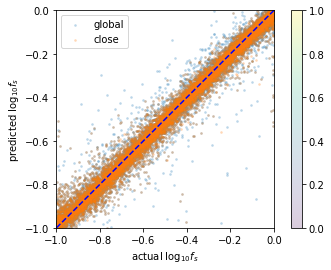

mse of log10fs global:  0.0021089923931907747
mse of log10fs close:  0.0012642058964950549
constraint 0.99774169921875
correct 0.9473297852817031


In [25]:
plt.axis('square')
plt.xlim(-1, 0)
plt.ylim(-1, 0)
plt.xlabel(r'actual $\log_{10}f_s$')
plt.ylabel(r'predicted $\log_{10}f_s$')
plt.scatter(Y[:num, 5], pred_global.numpy()[:num, 5], s=3, cmap='Blues', label='global', alpha=0.2)
plt.scatter(Y[:num, 5], pred_close.numpy()[:num, 5], s=3, cmap='Oranges', label='close', alpha=0.2)
plt.plot(np.linspace(-1, 0), np.linspace(-1, 0), color='b', linestyle='dashed')
plt.colorbar()
plt.legend()
plt.show()
print('mse of log10fs global: ', torch.mean((Y[:num, 5] -  pred_global.numpy()[:num, 5])**2).detach().cpu().item())
print('mse of log10fs close: ', torch.mean((Y[:num, 5] -  pred_close.numpy()[:num, 5])**2).detach().cpu().item())
constraint_ind = pred_global_loglik[:num, 5]>np.log(2*1/1)
print('constraint', torch.sum(constraint_ind).item()/num)
print('correct', torch.sum(pred_global[:num, 5][constraint_ind]==pred_close[:num, 5][constraint_ind]).item()/torch.sum(constraint_ind).item())

In [103]:
n_points = 100
subsample_ind = torch.argsort(torch.rand_like(X[:, :, 0]), dim=1)[:, :n_points]
X_sub = X[torch.arange(X.shape[0]).unsqueeze(-1), subsample_ind]
order = np.argsort(X_sub[:, :, 0].numpy(), axis=1)
X_sub = X_sub[torch.arange(X_sub.shape[0]).unsqueeze(-1), order]

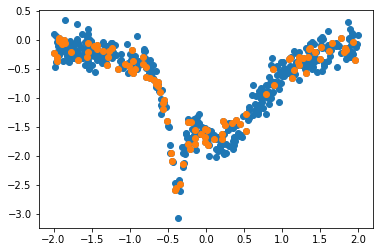

In [104]:
i = 0
plt.scatter(X[i, :, 0], X[i, :, 1])
plt.scatter(X_sub[i, :, 0], X_sub[i, :, 1])

In [105]:
# CDE interpolation with log_sig
depth = 3; window_length = n_points//100
logsig = torchcde.logsig_windows(X_sub, depth, window_length=window_length)
coeffs = torchcde.hermite_cubic_coefficients_with_backward_differences(logsig)

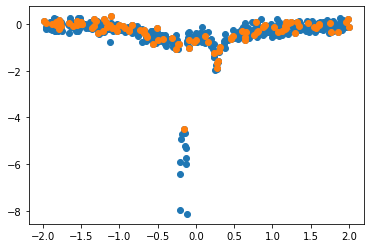

In [106]:
i = 1
plt.scatter(X[i, :, 0], X[i, :, 1])
plt.scatter(logsig[i, :, 0], logsig[i, :, 1])

In [107]:
num = 4096 * 4
batchsize = 4096
n_gaussian = model.n_gaussian
pis = torch.zeros((num, n_gaussian))
locs = torch.zeros((num, n_gaussian, output_dim))
scales = torch.zeros((num, n_gaussian, output_dim))
model.eval()
with torch.no_grad():
    for i in tqdm(range(int(np.ceil(num / batchsize)))):
        batch = coeffs[i*batchsize:min(i*batchsize+batchsize, num)].float().to(device)
        pi, normal = model(batch)
        pis[i*batchsize:min(i*batchsize+batchsize, num)] = pi.probs.detach().cpu()
        locs[i*batchsize:min(i*batchsize+batchsize, num)] = normal.loc.detach().cpu()
        scales[i*batchsize:min(i*batchsize+batchsize, num)] = normal.scale.detach().cpu()

  0%|          | 0/4 [00:00<?, ?it/s]

In [108]:
pred_global = torch.zeros((num, output_dim))
pred_global_loglik = torch.zeros((num, output_dim))
pred_close = torch.zeros((num, output_dim))
pred_close_loglik = torch.zeros((num, output_dim))
n_step = 1000
grid = [torch.linspace(0, 1, n_step),
        torch.linspace(-4, -2, n_step),
        torch.linspace(-4, 0, n_step),
        torch.linspace(-0.6, 0.6, n_step),
        torch.linspace(0, 2, n_step),
        torch.linspace(-1, 0, n_step)]
for dim in tqdm(range(output_dim)):
    param_list = grid[dim].reshape(-1, 1, 1).tile(1, num, 1) 
    loglik = get_loglik(pis, locs, scales, param_list, margin_dim=dim, exp=False).transpose(1, 0)
    for i in tqdm(range(num)):
        peaks = find_peaks(loglik[i])[0]
        if len(peaks) == 0:
            print('no peak found, use maximum instead')
            pred_global[i, dim] = grid[dim][torch.argmax(loglik[i])]
            pred_close[i, dim] = grid[dim][torch.argmax(loglik[i])]
            pred_global_loglik[i, dim] = torch.max(loglik[i])
            pred_close_loglik[i, dim] = torch.max(loglik[i])
            # plt.plot(grid[dim], loglik[i])
            # plt.vlines(Y[i, dim], 0, 10, color='red')
            # plt.vlines(grid[dim][torch.argmax(loglik[i])], 0, 10, color='blue')
            # print(Y[i, dim])
            # plt.show()
        else:
            order = torch.argsort(loglik[i, peaks], descending=True)
            global_peak = grid[dim][peaks[order[0]]]
            close_peak = grid[dim][peaks][torch.argmin((grid[dim][peaks] - Y[i, dim])**2)]
            pred_global[i, dim] = global_peak
            pred_close[i, dim] = close_peak
            pred_global_loglik[i, dim] = loglik[i][peaks[order[0]]]
            pred_close_loglik[i, dim] = loglik[i][peaks][torch.argmin((grid[dim][peaks] - Y[i, dim])**2)]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

no peak found, use maximum instead
no peak found, use maximum instead
no peak found, use maximum instead
no peak found, use maximum instead
no peak found, use maximum instead
no peak found, use maximum instead
no peak found, use maximum instead
no peak found, use maximum instead


  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

no peak found, use maximum instead
no peak found, use maximum instead
no peak found, use maximum instead
no peak found, use maximum instead
no peak found, use maximum instead
no peak found, use maximum instead
no peak found, use maximum instead


  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

no peak found, use maximum instead
no peak found, use maximum instead
no peak found, use maximum instead
no peak found, use maximum instead
no peak found, use maximum instead
no peak found, use maximum instead
no peak found, use maximum instead
no peak found, use maximum instead
no peak found, use maximum instead
no peak found, use maximum instead
no peak found, use maximum instead
no peak found, use maximum instead
no peak found, use maximum instead
no peak found, use maximum instead
no peak found, use maximum instead
no peak found, use maximum instead
no peak found, use maximum instead
no peak found, use maximum instead
no peak found, use maximum instead
no peak found, use maximum instead
no peak found, use maximum instead
no peak found, use maximum instead
no peak found, use maximum instead
no peak found, use maximum instead
no peak found, use maximum instead
no peak found, use maximum instead
no peak found, use maximum instead
no peak found, use maximum instead
no peak found, use m

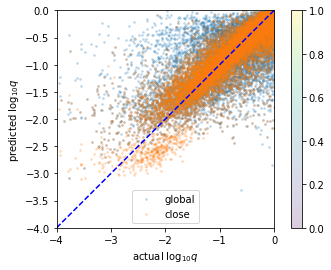

mse of log10q global:  0.20475559842674984
mse of log10q close:  0.09368279336737931
constraint 0.998046875
correct 0.7831457925636007


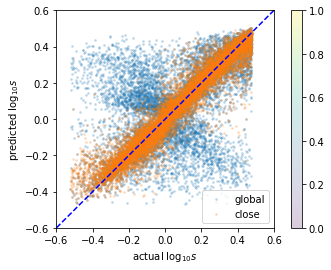

mse of log10s global:  0.03287575668116365
mse of log10s close:  0.0038249890807938946
constraint 0.99932861328125
correct 0.6802662920662066


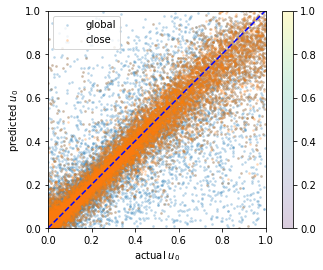

mse of u0:  0.023464153688166824
mse of u0:  0.008228018609945436
constraint 0.99005126953125
correct 0.7751679921089946


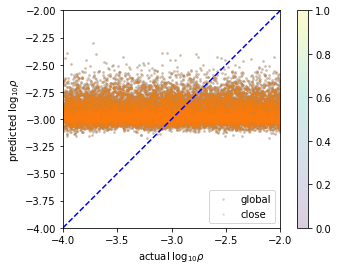

mse of log10rho global:  0.3458132253116205
mse of log10rho close:  0.3458132253116205
constraint 0.0


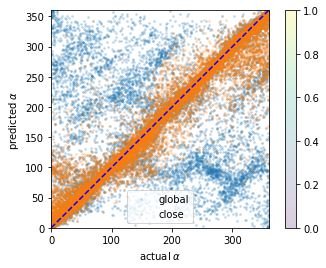

mse of alpha global:  9992.61564547908
mse of alpha close:  982.7367051646813
constraint 0.9859619140625
correct 0.6301225702612356


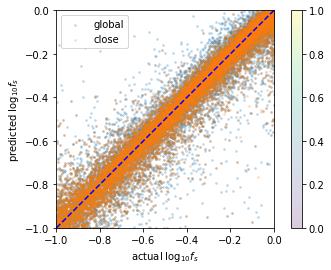

mse of log10fs global:  0.00874819313980181
mse of log10fs close:  0.00503168272480577
constraint 0.98724365234375
correct 0.8453168469860897


In [109]:
plt.axis('square')
plt.xlim(-4, 0)
plt.ylim(-4, 0)
plt.xlabel(r'actual $\log_{10}q$')
plt.ylabel(r'predicted $\log_{10}q$')
plt.scatter(Y[:num, 2], pred_global.numpy()[:num, 2], s=3, cmap='Blues', label='global', alpha=0.2)
plt.scatter(Y[:num, 2], pred_close.numpy()[:num, 2], s=3, cmap='Oranges', label='close', alpha=0.2)
plt.plot(np.linspace(-4, 0), np.linspace(-4, 0), color='b', linestyle='dashed')
plt.colorbar()
plt.legend()
plt.show()
print('mse of log10q global: ', torch.mean((Y[:num, 2] -  pred_global.numpy()[:num, 2])**2).detach().cpu().item())
print('mse of log10q close: ', torch.mean((Y[:num, 2] -  pred_close.numpy()[:num, 2])**2).detach().cpu().item())
constraint_ind = pred_global_loglik[:num, 2]>np.log(2*1/4)
print('constraint', torch.sum(constraint_ind).item()/num)
print('correct', torch.sum(pred_global[:num, 2][constraint_ind]==pred_close[:num, 2][constraint_ind]).item()/torch.sum(constraint_ind).item())
plt.axis('square')
plt.xlim(-0.6, 0.6)
plt.ylim(-0.6, 0.6)
plt.xlabel(r'actual $\log_{10}s$')
plt.ylabel(r'predicted $\log_{10}s$')
plt.scatter(Y[:num, 3], pred_global.numpy()[:num, 3], s=3, cmap='Blues', label='global', alpha=0.2)
plt.scatter(Y[:num, 3], pred_close.numpy()[:num, 3], s=3, cmap='Oranges', label='close', alpha=0.2)
plt.plot(np.linspace(-0.6, 0.6), np.linspace(-0.6, 0.6), color='b', linestyle='dashed')
plt.colorbar()
plt.legend()
plt.show()
print('mse of log10s global: ', torch.mean((Y[:num, 3] -  pred_global.numpy()[:num, 3])**2).detach().cpu().item())
print('mse of log10s close: ', torch.mean((Y[:num, 3] -  pred_close.numpy()[:num, 3])**2).detach().cpu().item())
constraint_ind = pred_global_loglik[:num, 3]>np.log(2*1/1.2)
print('constraint', torch.sum(constraint_ind).item()/num)
print('correct', torch.sum(pred_global[:num, 3][constraint_ind]==pred_close[:num, 3][constraint_ind]).item()/torch.sum(constraint_ind).item())
plt.axis('square')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel(r'actual $u_0$')
plt.ylabel(r'predicted $u_0$')
plt.scatter(Y[:num, 0], pred_global.numpy()[:num, 0], s=3, cmap='Blues', label='global', alpha=0.2)
plt.scatter(Y[:num, 0], pred_close.numpy()[:num, 0], s=3, cmap='Oranges', label='close', alpha=0.2)
plt.plot(np.linspace(0, 1), np.linspace(0, 1), color='b', linestyle='dashed')
plt.colorbar()
plt.legend()
plt.show()
print('mse of u0: ', torch.mean((Y[:num, 0] -  pred_global.numpy()[:num, 0])**2).detach().cpu().item())
print('mse of u0: ', torch.mean((Y[:num, 0] -  pred_close.numpy()[:num, 0])**2).detach().cpu().item())
constraint_ind = pred_global_loglik[:num, 0]>np.log(2*1/1)
print('constraint', torch.sum(constraint_ind).item()/num)
print('correct', torch.sum(pred_global[:num, 0][constraint_ind]==pred_close[:num, 0][constraint_ind]).item()/torch.sum(constraint_ind).item())
plt.axis('square')
plt.xlim(-4, -2)
plt.ylim(-4, -2)
plt.xlabel(r'actual $\log_{10}\rho$')
plt.ylabel(r'predicted $\log_{10}\rho$')
plt.scatter(Y[:num, 1], pred_global.numpy()[:num, 1], s=3, cmap='Blues', label='global', alpha=0.2)
plt.scatter(Y[:num, 1], pred_close.numpy()[:num, 1], s=3, cmap='Oranges', label='close', alpha=0.2)
plt.plot(np.linspace(-4, -2), np.linspace(-4, -2), color='b', linestyle='dashed')
plt.colorbar()
plt.legend()
plt.show()
print('mse of log10rho global: ', torch.mean((Y[:num, 1] -  pred_global.numpy()[:num, 1])**2).detach().cpu().item())
print('mse of log10rho close: ', torch.mean((Y[:num, 1] -  pred_close.numpy()[:num, 1])**2).detach().cpu().item())
constraint_ind = pred_global_loglik[:num, 1]>np.log(2*1/2)
print('constraint', torch.sum(constraint_ind).item()/num)
if torch.sum(constraint_ind).item() > 0:
    print('correct', torch.sum(pred_global[:num, 1][constraint_ind]==pred_close[:num, 1][constraint_ind]).item()/torch.sum(constraint_ind).item())
plt.axis('square')
plt.xlim(0, 360)
plt.ylim(0, 360)
plt.xlabel(r'actual $\alpha$')
plt.ylabel(r'predicted $\alpha$')
plt.scatter(Y[:num, 4]*180, pred_global.numpy()[:num, 4]*180, s=3, cmap='Blues', label='global', alpha=0.2)
plt.scatter(Y[:num, 4]*180, pred_close.numpy()[:num, 4]*180, s=3, cmap='Oranges', label='close', alpha=0.2)
plt.plot(np.linspace(0, 360), np.linspace(0, 360), color='b', linestyle='dashed')
plt.colorbar()
plt.legend()
plt.show()
print('mse of alpha global: ', torch.mean((Y[:num, 4]*180 -  pred_global.numpy()[:num, 4]*180)**2).detach().cpu().item())
print('mse of alpha close: ', torch.mean((Y[:num, 4]*180 -  pred_close.numpy()[:num, 4]*180)**2).detach().cpu().item())
constraint_ind = pred_global_loglik[:num, 4]>np.log(2*1/2)
print('constraint', torch.sum(constraint_ind).item()/num)
print('correct', torch.sum(pred_global[:num, 4][constraint_ind]==pred_close[:num, 4][constraint_ind]).item()/torch.sum(constraint_ind).item())
plt.axis('square')
plt.xlim(-1, 0)
plt.ylim(-1, 0)
plt.xlabel(r'actual $\log_{10}f_s$')
plt.ylabel(r'predicted $\log_{10}f_s$')
plt.scatter(Y[:num, 5], pred_global.numpy()[:num, 5], s=3, cmap='Blues', label='global', alpha=0.2)
plt.scatter(Y[:num, 5], pred_close.numpy()[:num, 5], s=3, cmap='Oranges', label='close', alpha=0.2)
plt.plot(np.linspace(-1, 0), np.linspace(-1, 0), color='b', linestyle='dashed')
plt.colorbar()
plt.legend()
plt.show()
print('mse of log10fs global: ', torch.mean((Y[:num, 5] -  pred_global.numpy()[:num, 5])**2).detach().cpu().item())
print('mse of log10fs close: ', torch.mean((Y[:num, 5] -  pred_close.numpy()[:num, 5])**2).detach().cpu().item())
constraint_ind = pred_global_loglik[:num, 5]>np.log(2*1/1)
print('constraint', torch.sum(constraint_ind).item()/num)
print('correct', torch.sum(pred_global[:num, 5][constraint_ind]==pred_close[:num, 5][constraint_ind]).item()/torch.sum(constraint_ind).item())